# 1. Introduction

This project is on implementing ML-based trace predictor. The trace is a continuous sequence of instructions not interrupted by any branches. Each trace is generated out of a sequence of basic blocks and, therefore, identified by the outcomes of branches. Trace id is a sequence of taken/not taken (1/0) outcomes being encoded into a single integer. For example, a trace with 3 branches where the first two branches are taken and the third one is not taken has a trace id of 5 (binary 101).

The main idea is to predict the trace id of the next trace based on the current trace id. The prediction is done by a machine learning model. The model is trained on a set of traces and their corresponding trace ids. The model is then used to predict the trace id of the next trace. The prediction is then compared to the actual trace id of the next trace. The accuracy of the prediction is measured by the number of correct predictions.

The features of the model are the identifiers of several previous traces. The longer history we record, the more accurate the prediction is. However, the longer the history, the more memory is required to store the history. The number of features is also limited by the number of bits in the trace id. For example, if the trace id is 32 bits, then the maximum number of features is 32. One other limitation is the complexity of the model. The more features we use, the more complex the model is and the higher is the possibility of overfitting.

We've decided to run the experiments on traces collected from some manually generated source files; also we've used traces collected from the suite libquantum of SPEC 2006 benchmark. Dofference between these datasets will be described in the section 2. Among all supervised learning models we've chosen the perceptron, neural network, decision trees (?? with ensembles ??). These models (and results of their execution) will be described in sections 3, 4, and 5. In addition to those static models, we've implemented an online learning model (based, again, on the perceptron) and compared its performance with the static models. The results of this experiment will be described in section 6.

# 2. Data collection and feature transform

## 2.1. Data collection

We've collected traces from two sources: manually generated source files and traces from the suite libquantum of SPEC 2006 benchmark. The first source is used to test the model on a small (and slightly trivial) dataset. The second source is used to test the model on a large real-world dataset.

### 2.1.1. Ifthenelse

This dataset was collected from the loop which body is the if-then-else diamond. Here is the code from this loop body:
```
if (i%7 == 0) {
    ...
    execute some instructions
    ...
} else {
    ...
    execute some other instructions
    ...
}
```
The loop has half a million iterations, so the dataset contains 500000 trace ids. The trace id is calculated as follows: if the condition is true, then the trace id is 1, otherwise it is 0. Therefore, there are two possible traces (or two classes for the prediction). There is a repetitive pattern in this datafile (1,0,0,0,0,0,0,1,0,0,...). So, with too large history, the model will be able to predict the trace id with 100% accuracy. However, for smaller history, the model should still be able to predict the trace id with high accuracy.

### 2.1.2. Consecutive

This dataset was collected from the loop which body is the consecutive diamond. Here is the code from this loop body:
```
if (i%3 != 0) {
    ...
    execute some instructions
    ...
} else {
    ...
    execute some other instructions
    ...
}
if (i%5 == 0) {
    ...
    execute some instructions
    ...
} else {
    ...
    execute some other instructions
    ...
}
```
The loop has half a million iterations, so the dataset contains 500000 trace ids. The trace id is calculated as follows: the first condition is responsible for the first bit, the second one -- for the second bit. Therefore, we have 4 traces: 0b00, 0b01, 0b10, 0b11; corresponding integer values would be 0, 1, 2, 3. Here the repetitive pattern would be of size 15 (1, 2, 2, 0, 2, 3, 0, 2, 2, 0, 3, 2, 0, 2, 2), however, we never have so many traces in the history, so this dataset will tell us how accurate would be the prediction in a more general case.

### 2.1.3. Nested

This dataset was collected from the loop which body is the nested diamond. Here is the code from this loop body:
```
if (i%7 != 0) {
    ...
    if (i%11 == 0){
        ...
    } else {
        ...
    }
} else {
    ...
}
if (i%3 != 0) {
    ...
} else {
    ...
}
if (i%5 == 0) {
    ...
} else {
    ...
}
```
The loop has half a million iterations, so the dataset contains 500000 trace ids. The maximum number of branches in one loop body is 4 (could be 3 if the first branch is not taken), therefore totally there are 16 possible traces with keys from 0 to 15. This is a more complex example since it's hard to find any repetitive patterns here, so we expect the prediction accuracy to be lower than in the previous examples. 

### 2.1.4. Libquantum

This dataset was collected from the loop in gates.c source file of 462.libquantum suite of SPEC 2006. Each loop has 2048 iterations, but it's kept in a function that's called more than 7k times, so the total number of iterations (and, therefore, total number of predictions) is near 15 million. The loop body has two nested branches, so total number of traces is 3: 0, 2, and 4. Despite the few amount of traces, this dataset is much more complex then the previous ones, because patterns are changing from instance to instance (from one subset of 2048 traces to the other) and predictor should still be able to keep predicting correctly.

## 2.2. Feature transform

As it was mentioned in the introduction, the features of the model are the identifiers of several previous traces. The longer history we record, the more accurate the prediction is. However, the longer the history, the more memory is required to store the history. The number of features is also limited by the number of bits in the trace id. For example, if the trace id is 32 bits, then the maximum number of features is 32. One other limitation is the complexity of the model. The more features we use, the more complex the model is and the higher is the possibility of overfitting. 

Each feature is identified by its id, therefore, here we have an integer encoding. One peculiar feature of such an encoding is that integer values have a natural ordered relationship between each other. Some ML models might use this ordering in training (perceptron, for example @@@???). This is not a desirable behaviour in this project -- trace 0 shouldn't be less predictable than trace 3. Integer encoding might mislead the model so it's necessary to transform features using another encoding. One example for categorical features would be one-hot encoding. Feature transform can be defined as follows: for 4 traces we can encode features using integer encoding (0, 1, 2, 3) or using one-hot encoding (0b0001, 0b0010, 0b0100, 0b1000). @@@ TODO: finish with something @@@


# 3. Perceptron-based predictor


### 3.1 Features encoding

In [25]:
import features as f
import tracePredictor
import perceptron

history_length = 4
num_of_classes = 16
ifthenelse_filepath  = 'datafiles/ifthenelse/predictionAccuracy.csv'
#libquantum_filepath  = 'datafiles/libquantum/predictionAccuracy.csv'
libquantum_filepath  = 'datafiles/short_libquantum/predictionAccuracy.csv'
nested_filepath      = 'datafiles/nested/predictionAccuracy.csv'
consecutive_filepath = 'datafiles/consecutive/predictionAccuracy.csv'

#no encoding
consecutive_no_features, consecutive_no_labels = f.generateTraceFeaturesWithoutTransform(consecutive_filepath, history_length, num_of_classes)
print ("Integer encoded features: ", consecutive_no_features.shape, " Labels: ", consecutive_no_labels.shape)

#bincode encoding
consecutive_bincode_features, consecutive_bincode_labels = f.generateBincodeTraceFeatures(consecutive_filepath, history_length, num_of_classes)
print ("Binary encoded features: ", consecutive_bincode_features.shape, " Labels: ", consecutive_bincode_labels.shape)

#one-hot encoding
consecutive_onehot_features, consecutive_onehot_labels = f.generateTraceFeatures(consecutive_filepath, history_length, num_of_classes)
print ("One-hot encoded features: ", consecutive_onehot_features.shape, " Labels: ", consecutive_onehot_labels.shape)


Integer encoded features:  (500496, 4)  Labels:  (500496,)
Binary encoded features:  (500496, 16)  Labels:  (500496,)
One-hot encoded features:  (500496, 64)  Labels:  (500496,)


With different dataset encoding we observe different number of features: for 16 classes and history length of 4 we have 4 features for integer encoding, 16 ($4 \times log_2(16) = 16$) features for binary encoding, 64 ($4 \times 16$) for one-hot encoding. Binary and one-hot encoding serves same purpose (encoding of categorical features, where the ordering is not important), the future experiments will be done with both of these encodings.


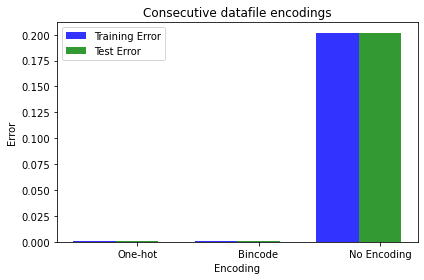

Integer encoded features:  (500496, 4)  Labels:  (500496,)
Binary encoded features:  (500496, 16)  Labels:  (500496,)
One-hot encoded features:  (500496, 64)  Labels:  (500496,)


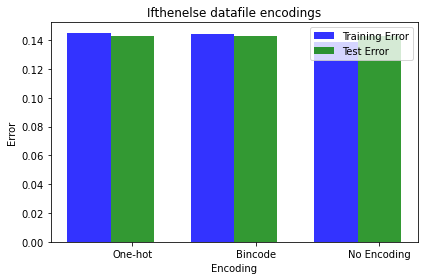

In [26]:
import numpy as np
import matplotlib.pyplot as plt

training_errors = []
test_errors = []
for (features, labels) in ((consecutive_onehot_features, consecutive_onehot_labels), (consecutive_bincode_features, consecutive_bincode_labels), (consecutive_no_features, consecutive_no_labels)):
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    training_dataset = features[:int(len(features)*0.05)]
    training_labels = labels[:int(len(labels)*0.05)]
    test_dataset = features[int(len(features)*0.05):]
    test_labels = labels[int(len(labels)*0.05):]
    _, num_of_features = training_dataset.shape

    perceptron_model = perceptron.perceptron(num_of_features, num_of_classes) # create the perceptron model
    trace_predictor = tracePredictor.tracePredictor(num_of_features, num_of_classes, perceptron_model) # create the trace predictor
    trace_predictor.training_dataset = training_dataset # set the training data
    trace_predictor.training_labels = training_labels # set the training labels
    trace_predictor.test_dataset = test_dataset # set the test data
    trace_predictor.test_labels = test_labels # set the test labels

    #print ("Training started!")
    trace_predictor.train() # train the model
    #print ("Training error: ", trace_predictor.training_error) # print the training error
    training_errors.append(trace_predictor.training_error)
    trace_predictor.predict() # test the model
    #print ("Test error: ", trace_predictor.test_error) # print the test error
    test_errors.append(trace_predictor.test_error)

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, training_errors, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Training Error')
rects2 = plt.bar(index + bar_width, test_errors, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')
plt.xlabel('Encoding')
plt.ylabel('Error')
plt.title('Consecutive datafile encodings')
plt.xticks(index + bar_width, ('One-hot encoding', 'Binary encoding', 'Integer encoding'))
plt.legend()
plt.tight_layout()
plt.show()

# Compare with ifthenelse (where we have only two traces: 0 and 1)
#no encoding
ifthenelse_no_features, ifthenelse_no_labels = f.generateTraceFeaturesWithoutTransform(ifthenelse_filepath, history_length, num_of_classes)
#bincode encoding
ifthenelse_bincode_features, ifthenelse_bincode_labels = f.generateBincodeTraceFeatures(ifthenelse_filepath, history_length, num_of_classes)
#one-hot encoding
ifthenelse_onehot_features, ifthenelse_onehot_labels = f.generateTraceFeatures(ifthenelse_filepath, history_length, num_of_classes)

training_errors = []
test_errors = []
for (features, labels) in ((ifthenelse_onehot_features, ifthenelse_onehot_labels), (ifthenelse_bincode_features, ifthenelse_bincode_labels), (ifthenelse_no_features, ifthenelse_no_labels)):
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    training_dataset = features[:int(len(features)*0.05)]
    training_labels = labels[:int(len(labels)*0.05)]
    test_dataset = features[int(len(features)*0.05):]
    test_labels = labels[int(len(labels)*0.05):]
    _, num_of_features = training_dataset.shape

    perceptron_model = perceptron.perceptron(num_of_features, num_of_classes) # create the perceptron model
    trace_predictor = tracePredictor.tracePredictor(num_of_features, num_of_classes, perceptron_model) # create the trace predictor
    trace_predictor.training_dataset = training_dataset # set the training data
    trace_predictor.training_labels = training_labels # set the training labels
    trace_predictor.test_dataset = test_dataset # set the test data
    trace_predictor.test_labels = test_labels # set the test labels

    #print ("Training started!")
    trace_predictor.train() # train the model
    #print ("Training error: ", trace_predictor.training_error) # print the training error
    training_errors.append(trace_predictor.training_error)
    trace_predictor.predict() # test the model
    #print ("Test error: ", trace_predictor.test_error) # print the test error
    test_errors.append(trace_predictor.test_error)

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, training_errors, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Training Error')
rects2 = plt.bar(index + bar_width, test_errors, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')
plt.xlabel('Encoding')
plt.ylabel('Error')
plt.title('Ifthenelse datafile encodings')
plt.xticks(index + bar_width, ('One-hot encoding', 'Binary encoding', 'Integer encoding'))
plt.legend()
plt.tight_layout()
plt.show()


As we can see on the example of the "consecutive" datafile, integer encoding leads to the bigger error. In this datafile there are up to 4 possible traces and perceptron model seems to be mistrained when the integer encoding is used. Binary encoding and one-hot encoding lead to the similar error rate, which means they are both suitable for fixing this issue.

To compare, we also run the model with the "ifthenelse" datafile. Here the integer encoding does not lead to the bigger error, because there are only two traces (0 and 1) and there is no bias of the prediction of traces with higher ids. The error rate is relatively high, however, it's high with all encodings due to model underfitting (it will be studied in more details further).

### 3.2 Different datasets

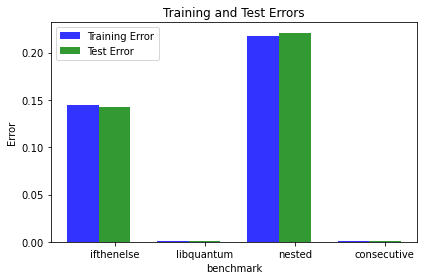

In [27]:
weights = []
training_errors = []
test_errors = []

for datafile in (ifthenelse_filepath, libquantum_filepath, nested_filepath, consecutive_filepath):
    features, labels = f.generateTraceFeatures(datafile, history_length, num_of_classes)
    #print ("Features: ", features.shape, " Labels: ", labels.shape)

    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)
    features = features[indices]
    labels = labels[indices]

    training_dataset = features[:int(len(features)*0.05)]
    training_labels = labels[:int(len(labels)*0.05)]
    test_dataset = features[int(len(features)*0.05):]
    test_labels = labels[int(len(labels)*0.05):]
    _, num_of_features = training_dataset.shape

    perceptron_model = perceptron.perceptron(num_of_features, num_of_classes) # create the perceptron model
    trace_predictor = tracePredictor.tracePredictor(num_of_features, num_of_classes, perceptron_model) # create the trace predictor
    trace_predictor.training_dataset = training_dataset # set the training data
    trace_predictor.training_labels = training_labels # set the training labels
    trace_predictor.test_dataset = test_dataset # set the test data
    trace_predictor.test_labels = test_labels # set the test labels

    #print ("Training started!")
    trace_predictor.train() # train the model
    #print ("Training error: ", trace_predictor.training_error) # print the training error
    trace_predictor.predict() # test the model
    #print ("Test error: ", trace_predictor.test_error) # print the test error

    weights.append(perceptron_model.weights)
    training_errors.append(trace_predictor.training_error)
    test_errors.append(trace_predictor.test_error)

fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, training_errors, bar_width,
                    alpha=opacity,
                    color='b',
                    label='Training Error')

rects2 = plt.bar(index + bar_width, test_errors, bar_width,
                    alpha=opacity,
                    color='g',
                    label='Test Error')

plt.xlabel('benchmark')
plt.ylabel('Error')
plt.title('Training and Test Errors')
plt.xticks(index + bar_width, ('ifthenelse', 'libquantum', 'nested', 'consecutive'))
plt.legend()

plt.tight_layout()
plt.show()




According to this bar graph, perceptron-based predictor works well with "consecutive" and "libquantum" datafiles. The last one is counterintuitive until the form of the loop is understood.
As it was stated before, libquantum has a loop function that is called more than 7k times. Each time the function is called, it has 2048 iterations. Loop body is relatively simple itself (as a control-flow graph), and first several iterations is enough for the model to learn the pattern. All other iterations are then being predicted correctly. So, even though the pattern is changing every 2048 iterations, this model requires quite a few training data to be able to predict traces from this dataset correctly.

"Ifthenelse" datafile has around 14% error rate which correlates with the ratio of traces with id 1 to the total number of traces. This dataset (and, also, "nested") will be good datasets to check how complex should be the model to be able to predict traces correctly. 

### 3.3 Different history lengths

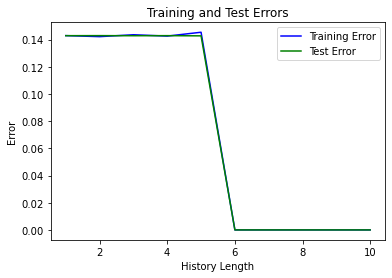

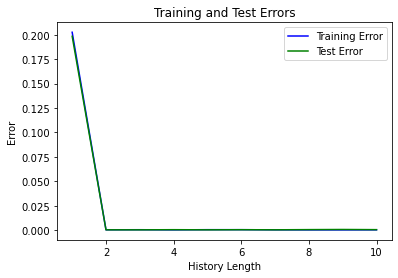

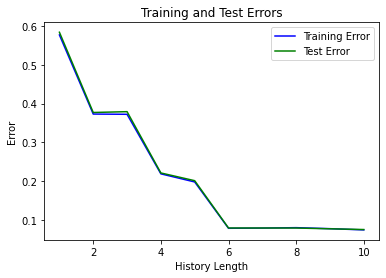

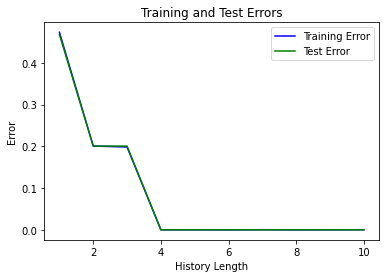

In [28]:


for filepath in (ifthenelse_filepath, libquantum_filepath, nested_filepath, consecutive_filepath):
    training_errors = []
    test_errors = []
    for history_length in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10):
        features, labels = f.generateTraceFeatures(filepath, history_length, num_of_classes)
        #print ("Features: ", features.shape, " Labels: ", labels.shape)

        indices = np.arange(features.shape[0])
        np.random.shuffle(indices)
        features = features[indices]
        labels = labels[indices]

        training_dataset = features[:int(len(features)*0.05)]
        training_labels = labels[:int(len(labels)*0.05)]
        test_dataset = features[int(len(features)*0.05):]
        test_labels = labels[int(len(labels)*0.05):]
        _, num_of_features = training_dataset.shape

        perceptron_model = perceptron.perceptron(num_of_features, num_of_classes)
        trace_predictor = tracePredictor.tracePredictor(num_of_features, num_of_classes, perceptron_model)
        trace_predictor.training_dataset = training_dataset
        trace_predictor.training_labels = training_labels
        trace_predictor.test_dataset = test_dataset
        trace_predictor.test_labels = test_labels

        #print ("Training started!")
        trace_predictor.train()
        #print ("Training error: ", trace_predictor.training_error)
        trace_predictor.predict()
        #print ("Test error: ", trace_predictor.test_error)

        training_errors.append(trace_predictor.training_error)
        test_errors.append(trace_predictor.test_error)

    # plot the training and test errors (scatter plot)
    fig, ax = plt.subplots()
    ax.plot(np.arange(1, 11), training_errors, color='b', label='Training Error')
    ax.plot(np.arange(1, 11), test_errors, color='g', label='Test Error')
    ax.set_xlabel('History Length')
    ax.set_ylabel('Error')
    ax.set_title('Training and Test Errors')
    ax.legend()
    plt.show()
    




TODO: Describe the results

### 3.4 Different ratio of training data

TODO: plot and describe the results

# APPLY FOR ALL STATIC MODELS!
---------------------------------

## 3.0 Different datasets

## 3.1 Different feature transform functions

## 3.2 Different number of features (history length)

## 3.3 Different model parameters (might mean different things for different models)

## 3.4 Different split of training and testing data

----------------------------------


# 4. Neural net (multi-layer perceptron)

# 5. Decision trees and random forests


In this section we focus on develping the decision tree model and its ensamble called random forest. Our trace predictor is regarded as a supervised classifier for trace ID. The classifier uses the preceded trace IDs to predict the ID of the next trace. The decision tree model and the random forest model can be therefore the possible options for this purpose.   

However, before training decision trees and randome forest, we have to determine the characteristics, so called "hyperparameters', which control the shape of the models. The common hyperparameters for decision trees and random forests are the maximum depth of the trees, the minumum number of sampls to split the node, and the minimum number of samples to make a leaf. Additionally, the number of estimators is unique to random forest. The selection of these hyperparameters depends on dataset and might affect the model performance. For this reason, choosing hyperperameter is one of the major problems when we apply decision trees and random forests.     

Hyperprameter selection is regarded as an optimization problem that tries to find a set of hyperparameters that optimize the model performance. Because the hyperparameters for the models only take discrete integer values, this problem is a combinatorial optimization. Trying every combination of hyperparameters (called "grid search method") could identify the optimal set of hyperparameters but usually leads to high computational complexity as the hyperparameter space grows. It is therefore necessary to apply a strategy for efficient hyperparameter selection.        

## 3.1 Hyperparameter selection experiment
We first investigate whether or not the selection of hyperparameters matters. If the performance of a model does not depend on the choice of hyperparameter, we can arbitrarily select hyperparameters. We thus compare the performance of models with different hyperparameters for each dataset.  

We train the two-type models on randomly selected hyperparameter sets and test their performance. We randomly draw 1% (or 0.1% only for libquantum dataset because of its size) out of each dataset as a training data and leave the rest as a test dataset. We then train 100 models with different hyperparameter sets and test them. The branching criterion can be thought to be a hyperparameter, but we only use enthoropy for this project. In addition, the length of history is set to be three, and the one-hot encoding is used for feature transformation.  The hyperparameter space where each hyperparameter is selected is defined as:
- Maximum depth $= [1,2,3,4,5,7,10,15,20,25,30,35,40,50]$
- Minimum number of points to split $= [2^1,2^2, \cdots ,2^8]$
- Minimum number of points to in each leaf  $= [2^0,2^1, \cdots ,2^8]$
- Number of estimators = $[1,2, \cdots ,50]$

The total number of combinations of hyperparames is $1008 ( = 14 \times 8 \times 9)$ for decision tree and $48384 ( = 1008 \times 48)$ for random forest respectively.

First, training and test error rates from the 50 models on the same split of each dataset are plotted. According to those plot, we found that whatever hyperparameters we choose for the ifthenelse dataset the error rates are almost the same. This means that we can arbitrary choose hyperparameters for decision trees and random forest models for this dataset. For the other datasets, we can observe variations in errors. This result shows that the selection of hyperparmeters will affect the model performance on those dataset. 

Next, we examine which hyperparameter potentially affects the model performance. For this purpose, training and test errors are plotted against each value of hyperparameters. As we expected, training and test errors from ifthenelse and consecutive data are almost the same for any value of hyperparameter except that a smaller depth and a larger minimum number in leaf (for random forest) might lead to a higher error rate in consecutive data. For other datasets, error rates varies depending on hyperparameters. Specifically, a small depth of trees and a larger minimum number in leaf might seem to cause a higher error rates both from decision tree and random forest models. 

The result of this experiment shows that hyperparameter selection will affect on the model performance. This effect is larger for more complicated datasets such as nested or libquantum. It is therefore clear, we need to implement a hyperparameter selection methodology for decision-tree-based trace predictors.

In [2]:
import tracePredictor_DT
import decisionTree
import features as ft
import numpy as np
import matplotlib.pyplot as plt

history_length = 4
num_of_classes = 16

#type = ['ifthenelse', 'consecutive', 'nested', 'libquantum']
type = ['ifthenelse', 'nested']

for f in range(len(type)):
    # Set up datasets
    print(type[f])
    filePath = 'datafiles/'  + type[f] + '/predictionAccuracy.csv' 

    print ("Binary classifier transform: ")
    classfeatures, classlabels = ft.generateTraceFeatures(filePath, history_length, num_of_classes)
    print ("Features: ", classfeatures.shape, " Labels: ", classlabels.shape)
    
    indices = np.arange(classfeatures.shape[0])
    np.random.shuffle(indices)
    features = classfeatures[indices]
    labels = classlabels[indices]

    #Split into training and test datasets
    if (type[f] != 'libquantum'):
        percentage = 0.01
    else:
        percentage = 0.001
    training_dataset = features[:int(len(features)*percentage)]
    training_labels = labels[:int(len(labels)*percentage)]
    test_dataset = features[int(len(features)*percentage):]
    test_labels = labels[int(len(labels)*percentage):]

    _, num_of_features = training_dataset.shape

    #Define a parameter space
    depth = [1,2,3,4,5,7,10,15,20,25,30,35,40,50]
    min_split = [2,4,8,16,32,64,128,256]
    min_leaf = [1,2,4,8,16,32,64,128,256]
    n_estimators =  np.linspace(1, 50, 50, dtype = int)

    #Random sampling from the parameter space
    num_trial = 50
    #models = [None] *  num_trial

    eRates_DT_tr = [None] *  num_trial
    eRates_DT_te = [None] *  num_trial
    eRates_RF_tr = [None] *  num_trial
    eRates_RF_te = [None] *  num_trial
    
    params = [None] *  num_trial
    
    for i in range(num_trial):
        #print('Sample', i)
        ind = np.random.randint(0, [len(depth), len(min_split), len(min_leaf), len(n_estimators)])
        params[i] = [depth[ind[0]], min_split[ind[1]], min_leaf[ind[2]], n_estimators[ind[3]]]

        #Train decision tree and predict
        model = decisionTree.decisionTree(num_classes = num_of_classes, max_depth = params[i][0], num_min_split = params[i][1], num_min_leaf = params[i][2])
        trace_predictor = tracePredictor_DT.tracePredictor(num_of_features, num_of_classes, model) # create the trace predictor
        trace_predictor.training_dataset = training_dataset # set the training data
        trace_predictor.training_labels = training_labels # set the training labels
        trace_predictor.test_dataset = test_dataset # set the test data
        trace_predictor.test_labels = test_labels # set the test labels
        eRates_DT_tr[i] = trace_predictor.train()
        eRates_DT_te[i] = trace_predictor.predict() 

        #Train random forest and predict
        model = decisionTree.randomForest(num_classes = num_of_classes, max_depth = params[i][0], num_min_split = params[i][1], num_min_leaf = params[i][2], num_estimator = params[i][3])
        trace_predictor = tracePredictor_DT.tracePredictor(num_of_features, num_of_classes, model) # create the trace predictor
        trace_predictor.training_dataset = training_dataset # set the training data
        trace_predictor.training_labels = training_labels # set the training labels
        trace_predictor.test_dataset = test_dataset # set the test data
        trace_predictor.test_labels = test_labels # set the test labels
        eRates_RF_tr[i] = trace_predictor.train()
        eRates_RF_te[i] = trace_predictor.predict() 

    minRate = np.min([eRates_DT_tr,eRates_DT_te, eRates_RF_tr, eRates_RF_te])
    maxRate = np.max([eRates_DT_tr,eRates_DT_te, eRates_RF_tr, eRates_RF_te])

    lowerbound = np.floor(minRate*20)/20
    upperbound = np.ceil(maxRate*20)/20

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle('Error rates of models with ramdomly sampled hyperparameters:' + type[f], fontsize=9)
    ax[0].set_xlim([lowerbound, upperbound])
    ax[0].set_ylim([lowerbound, upperbound])
    ax[1].set_xlim([lowerbound, upperbound])
    ax[1].set_ylim([lowerbound, upperbound])
    ax[0].set_xlabel('Training error rate')
    ax[0].set_ylabel('test error rate')
    ax[1].set_xlabel('Training error rate')
    ax[0].set_title('Decision tree', fontsize=9)
    ax[1].set_title('Random forest', fontsize=9)
    ax[0].plot(eRates_DT_tr, eRates_DT_te,'o', label = 'Decision Tree' )
    ax[1].plot(eRates_RF_tr, eRates_RF_te,'o', label = 'Random Forest' )
    plt.savefig('errors_random_' + type[f] + '_hist' + str(history_length) + '.png')
    plt.show()

    params = np.array(params,dtype=int)
    fig, ax = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
    fig.suptitle('Error rate of models with each hyperparameter:' + type[f] +  '(top: DT, bottom: RF)')
    ax[0,0].set_xlim([0, np.max(depth)+2])
    ax[0,0].set_ylim([lowerbound, upperbound])
    ax[0,0].set_ylabel('Error rate')
    ax[1,0].set_xlabel('Max depth')
    ax[1,0].set_ylabel('Error rate')
    ax[1,0].set_xlim([0, np.max(depth)+2])
    ax[1,0].set_ylim([lowerbound, upperbound]) 
    ax[0,0].plot(params[:,0], eRates_DT_tr,'o', label='Trainning (DT)')
    ax[1,0].plot(params[:,0], eRates_RF_tr,'o', label='Trainning (RF)')
    ax[0,0].plot(params[:,0], eRates_DT_te,'o', label='Test (DT)')
    ax[1,0].plot(params[:,0], eRates_RF_te,'o', label='Test (RF)')

    ax[0,1].set_xlim([0, np.max(min_split)+2])
    ax[0,1].set_ylim([lowerbound, upperbound]) 
    ax[1,1].set_xlabel('Min number of split')
    ax[1,1].set_xlim([0, np.max(min_split)+2])
    ax[1,1].set_ylim([lowerbound, upperbound]) 
    ax[0,1].plot(params[:,1], eRates_DT_tr,'o', label='Trainning (DT)')
    ax[1,1].plot(params[:,1], eRates_RF_tr,'o', label='Trainning (RF)')
    ax[0,1].plot(params[:,1], eRates_DT_te,'o', label='Test (DT)')
    ax[1,1].plot(params[:,1], eRates_RF_te,'o', label='Test (RF)')

    ax[0,2].set_xlim([0, np.max(min_leaf)+2])
    ax[0,2].set_ylim([lowerbound, upperbound]) 
    ax[1,2].set_xlabel('Min number in leaf')
    ax[1,2].set_xlim([0, np.max(min_leaf)+2])
    ax[1,2].set_ylim([lowerbound, upperbound])   
    ax[0,2].plot(params[:,2], eRates_DT_tr,'o', label='Trainning (DT)')
    ax[1,2].plot(params[:,2], eRates_RF_tr,'o', label='Trainning (RF)')
    ax[0,2].plot(params[:,2], eRates_DT_te,'o', label='Test (DT)')
    ax[1,2].plot(params[:,2], eRates_RF_te,'o', label='Test (RF)')

    ax[1,3].set_xlabel('Number of estimators')
    ax[1,3].set_xlim([0, np.max(n_estimators)+2])
    ax[1,3].set_ylim([lowerbound, upperbound]) 
    ax[1,3].set_xticks(np.arange(0, np.max(n_estimators), 5))
    ax[1,3].plot(params[:,3], eRates_RF_tr,'o', label='Trainning')
    ax[1,3].plot(params[:,3], eRates_RF_te,'o', label='Test')
    ax[1,3].legend(loc='upper left', bbox_to_anchor=(0, 1.5))
    ax[0,3].set_axis_off()

    plt.savefig('errors_parameters_random_'+ type[f] + '_hist'+ str(history_length) + '.png')
    plt.show()



ifthenelse
Binary classifier transform: 


KeyboardInterrupt: 

## 3.2 Hyperparameter selection by random search algorithm
Since it is almost impossible to apply the grid search to find the best hyperparamters due to its computational complexity, we use the random search algorithm instead. This algorithm repeats drawing a ramdom set of parameters and evaluating an objective function. Among the draws, the set which leads to the most optimal value of the objective function is regarded as the optimum point. This algorithm may not lead to an actual optimum without sufficient draws but at least will help find points close to the optimum and reduce the complexity.  

We use the sklearn package to implement the random search algorithm. In this algorithm, the score for each draw is evalueted by the 5-fold validation implemented as default. This means that, for one draw of parameters, the model is evaluated on five different splits of training dataset and the mean of these five evaluations will be the the score of the parameter draw. We use 100 draws to pick the best set of parameters. 

We examine the stability of the parameter by applying this method to different training datasets. We additionally apply the bootstrap method so that we can collect different hyerparameter sets that are searched from 50 randomly sampled training datasets. Using these estimated hyperparameters, we could identify the best one or estimate the distribution of the best hyperparameters. The settings of estimation are same as the previou part.  

For the ifthenelse dataset, the test errors achieve almost the same value even though we used different data splits. Moreover, as we expected, the parameters estimated by random search are more randomly distributed than those from other datasets. Therefore, it does not seem that hyperparameter selection has something to do with the model performance on this dataset in terms of accuracy although some values of the paramters are chosen more frequently than others.  

The estimation from the consecutive dataset shows certain (but still small) variation around 20% among the test error rates. On the other hand, some the hyperparameter distributions do not seem perfectly random. For example, for both datasets, a tree of one depth is not selected, and the minimum number in leaf of one is much more often selected than other values. while the model performance of the two models does not show considarable a difference, the random forest model seems to prefer larger depth than decision tree.

Thirdly, the nested dataset results in a larger variation of test error rates and has smaller ranges of some of the hyperparameters such as the maximum depth and the minimum number in leaf. The test error rates for both models are around 0.37 which is the largest among our four datasets.The depths of smaller than seven are not estimated for both models, and the minimum number in leaf concentrates more in smaller values than the consecutive dataset. Meanwhile, the distributions of other two hyperparameters do not show a significant characteristic. 

The libquantum dataset, regarded as the most complex dataset, finally generates a result which is close to the consecutive in terms of the test error rates. The distribution of the estimated maximum depth does not have values smaller than 4, and that of the minimum number in leaf does not have values larger than sixty four. These results are counter-intuitive considering the data complexity, but we cannot figure out a reasonable explanation at this point of time.

The table below summarizes the most frequently selected hyperparameters for each model and each datasets. Note that this result is only from one experiment and may differ from another trial but will work for reference. In addition, this result would look different if we use another split which has higher rate of training dataset.  

| Parameters              | ifthenelse     || Consecutive |     | Nested |    | Libquantum |     |
|------------------------:|-----------:|---:|------------:|----:|-------:|---:|-----------:|----:|
|                         | DT         | RF | DT          | RF  | DT     | RF | DT         | RF  |
| Maximum depth           | 25         | 1  | 7           | 50  | 30     | 50 | 5          | 5   |
| Minimum number of split | 16         | 16 | 8           | 128 | 1      | 8  | 2          | 64  |
| Minimum number in leaf  | 1          | 64 | 1           | 1   | 1      | 1  | 4          | 8   |
| Number of estimators    | -          | 23 | -           | 1   | -      | 21 | -          | 7   |

From this experiment we do not find the identical "best" values for hyperparameters but "preferable" ranges for some of them. The model performance does not significantly change within this range.  Additionally, the random search algorithm takes longer time for computation. We could instead use Bayesian estimation to find desirable hyperparameters more efficiently.

ifthenelse
Binary classifier transform: 
Features:  (500496, 64)  Labels:  (500496,)
Minimum test error rate (DT):  0.14274700701524945
Minimum test error rate (RF):  0.14274700701524945


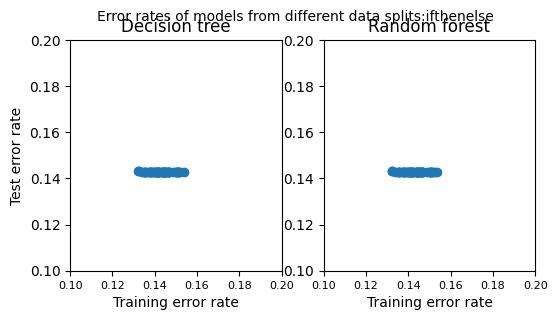

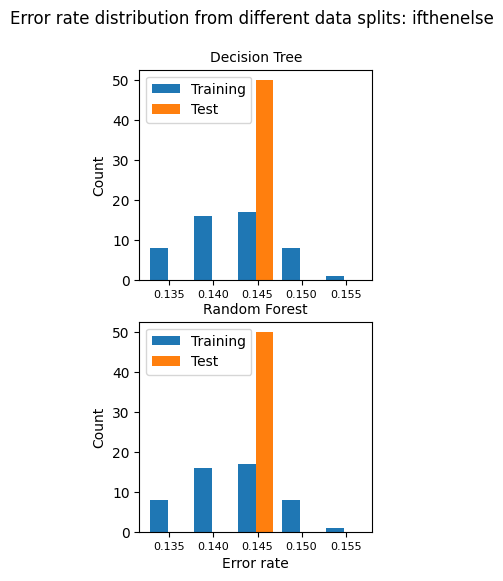

Most frequent parameters
Max depth (DT):  50
Min number of split (DT):  256
Min number in leaf (DT):  32
Max depth (RF):  50
Min number of split (RF):  64
Min number in leaf (RF):  1
Number of estimators (RF):  33


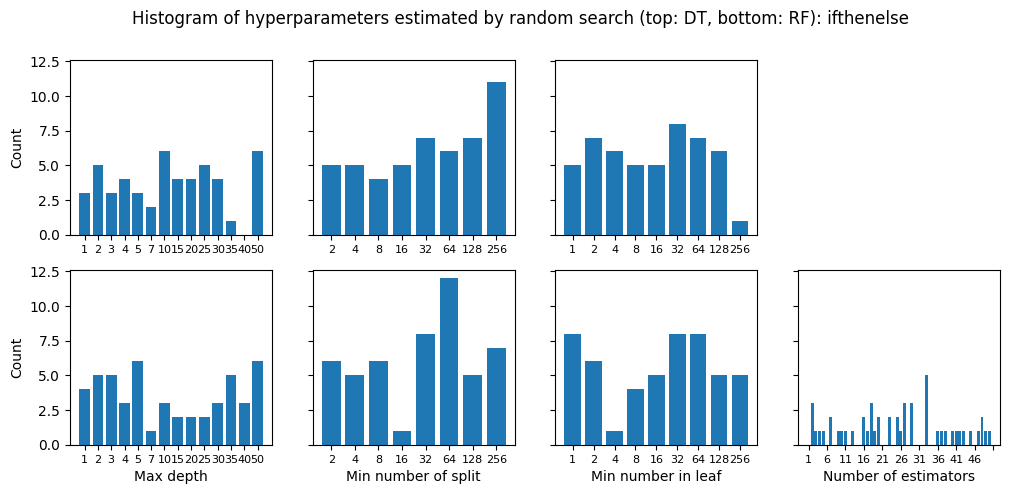

nested
Binary classifier transform: 
Features:  (500496, 64)  Labels:  (500496,)
Minimum test error rate (DT):  0.22092384942642873
Minimum test error rate (RF):  0.22080679405520165


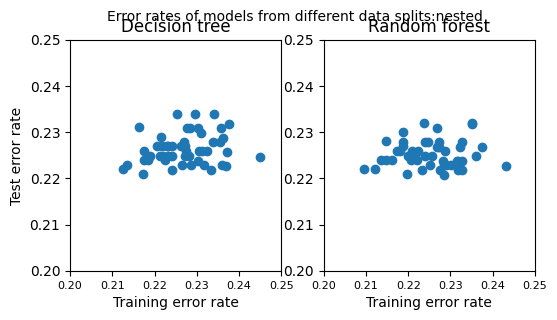

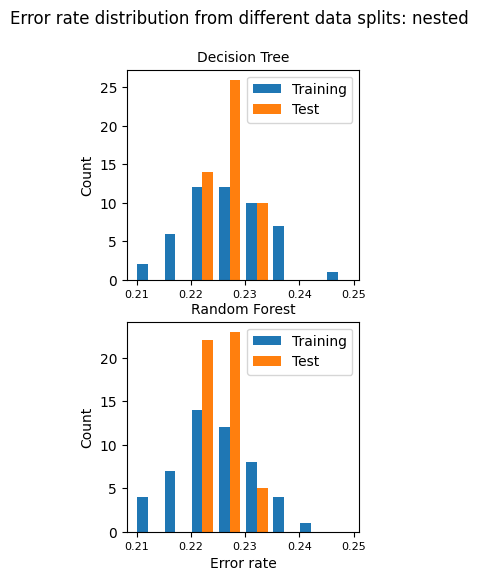

Most frequent parameters
Max depth (DT):  20
Min number of split (DT):  4
Min number in leaf (DT):  1
Max depth (RF):  30
Min number of split (RF):  2
Min number in leaf (RF):  1
Number of estimators (RF):  27


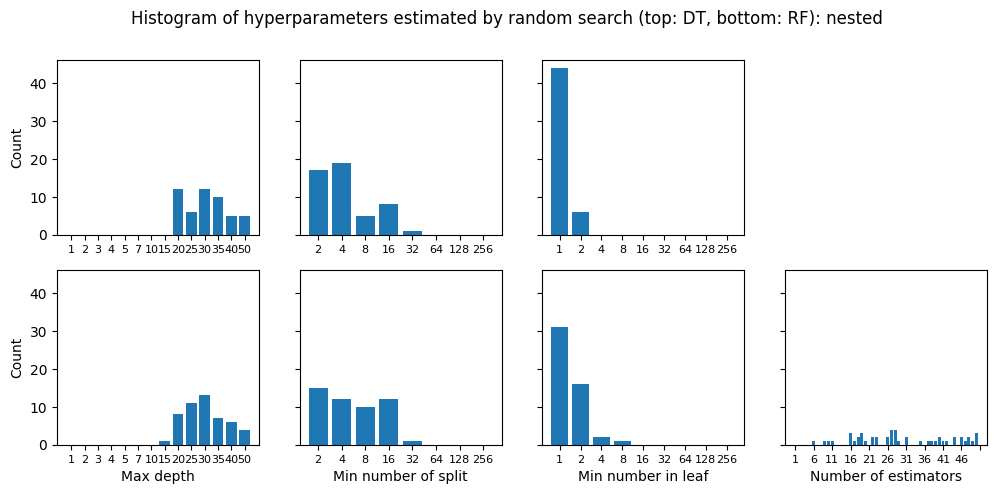

In [6]:
from statistics import mode

for f in range(len(type)):
    # Set up datasets
    print(type[f])
    filePath = 'datafiles/'  + type[f] + '/predictionAccuracy.csv' 

    print ("Binary classifier transform: ")
    classfeatures, classlabels = ft.generateTraceFeatures(filePath, history_length, num_of_classes)
    print ("Features: ", classfeatures.shape, " Labels: ", classlabels.shape)
    
    #Random sampling from the parameter space
    num_trial = 50

    eRates_DT_tr = [None] *  num_trial
    eRates_DT_te = [None] *  num_trial
    eRates_RF_tr = [None] *  num_trial
    eRates_RF_te = [None] *  num_trial
    params_DT = [None] *  num_trial
    params_RF = [None] *  num_trial

    _, num_of_features = classfeatures.shape

    #Define a parameter space
    depth = np.array([1,2,3,4,5,7,10,15,20,25,30,35,40,50],dtype = int)
    min_split = np.array([2,4,8,16,32,64,128,256], dtype = int)
    min_leaf = np.array([1,2,4,8,16,32,64,128,256], dtype = int)
    n_estimators =  np.linspace(1, 50, 50, dtype = int)

    for i in range(num_trial):
        #print('Sample', i)

        indices = np.arange(classfeatures.shape[0])
        np.random.shuffle(indices)
        features = classfeatures[indices]
        labels = classlabels[indices]

        #Split into training and test datasets
        if (type[f] == 'libquantum'):
            percentage = 0.001
        else:
            percentage = 0.01
        training_dataset = features[:int(len(features)*percentage)]
        training_labels = labels[:int(len(labels)*percentage)]
        test_dataset = features[int(len(features)*percentage):]
        test_labels = labels[int(len(labels)*percentage):]

        ind = np.random.randint(0, [len(depth), len(min_split), len(min_leaf), len(n_estimators)])
        params_DT[i] = [depth[ind[0]], min_split[ind[1]], min_leaf[ind[2]], n_estimators[ind[3]]]

        #Train decision tree and predict
        model = decisionTree.selectedDT_RondomSearch(num_classes = num_of_classes, max_depth = depth, num_min_split = min_split, num_min_leaf = min_leaf)
        trace_predictor = tracePredictor_DT.tracePredictor(num_of_features, num_of_classes, model) # create the trace predictor
        trace_predictor.training_dataset = training_dataset # set the training data
        trace_predictor.training_labels = training_labels # set the training labels
        trace_predictor.test_dataset = test_dataset # set the test data
        trace_predictor.test_labels = test_labels # set the test labels
        tree = trace_predictor.train()
        eRates_DT_tr[i] = 1 - tree.best_score_
        params_DT[i] = [tree.best_params_['max_depth'], tree.best_params_['min_samples_split'], tree.best_params_['min_samples_leaf']]
        eRates_DT_te[i] = trace_predictor.predict() 

        #Train random forest and predict
        model = decisionTree.selectedRF_RandomSearch(num_classes = num_of_classes, max_depth = depth, num_min_split = min_split, num_min_leaf = min_leaf, num_estimator = n_estimators)
        trace_predictor = tracePredictor_DT.tracePredictor(num_of_features, num_of_classes, model) # create the trace predictor
        trace_predictor.training_dataset = training_dataset # set the training data
        trace_predictor.training_labels = training_labels # set the training labels
        trace_predictor.test_dataset = test_dataset # set the test data
        trace_predictor.test_labels = test_labels # set the test labels
        forest = trace_predictor.train()
        eRates_RF_tr[i] = 1 - forest.best_score_
        params_RF[i] = [forest.best_params_['max_depth'], forest.best_params_['min_samples_split'], forest.best_params_['min_samples_leaf'], forest.best_params_['n_estimators']]
        eRates_RF_te[i] = trace_predictor.predict() 

    #Show the lowest test error rate.
    print('Minimum test error rate (DT): ', np.min(eRates_DT_te))
    print('Minimum test error rate (RF): ', np.min(eRates_RF_te))

    minRate = np.min([eRates_DT_tr,eRates_DT_te, eRates_RF_tr, eRates_RF_te])
    maxRate = np.max([eRates_DT_tr,eRates_DT_te, eRates_RF_tr, eRates_RF_te])

    lowerbound = np.floor(minRate*20)/20
    upperbound = np.ceil(maxRate*20)/20

    #Show the error rates.
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle('Error rates of models from different data splits:' + type[f], fontsize = 10)
    ax[0].set_xlim([lowerbound, upperbound])
    ax[0].set_ylim([lowerbound, upperbound])
    ax[1].set_xlim([lowerbound, upperbound])
    ax[1].set_ylim([lowerbound, upperbound])
    ax[0].set_xlabel('Training error rate')
    ax[0].set_ylabel('Test error rate')
    ax[1].set_xlabel('Training error rate')
    ax[0].set_title('Decision tree')
    ax[1].set_title('Random forest')
    ax[0].plot(eRates_DT_tr, eRates_DT_te,'o', label = 'Decision Tree' )
    ax[1].plot(eRates_RF_tr, eRates_RF_te,'o', label = 'Random Forest' )
    plt.savefig('plot_error_sample_' + type[f] + '_hist' + str(history_length) + '.png')
    plt.show()

    binwidth = 0.005
    bin=np.arange(minRate, maxRate + binwidth, binwidth)
    fig, ax = plt.subplots(2, 1, figsize=(3, 6))
    fig.suptitle('Error rate distribution from different data splits: '+ type[f], fontsize = 12)
    ax[0].set_title('Decision Tree', fontsize = 10)
    ax[1].set_title('Random Forest', fontsize = 10)
    ax[1].set_xlabel('Error rate')
    ax[0].set_ylabel('Count')
    ax[1].set_ylabel('Count')
    ax[0].hist([eRates_DT_tr,eRates_DT_te], bins = bin, label = ['Training', 'Test'])
    ax[1].hist([eRates_RF_tr, eRates_RF_te], bins = bin, label = ['Training', 'Test'])  
    ax[0].legend()
    ax[1].legend()
    plt.savefig('histo_error_sample_'+ type[f] +'_hist' + str(history_length) +'.png')
    plt.show()

    #Show the most frequent parameters.
    params_DT = np.array(params_DT,dtype=int)
    params_RF = np.array(params_RF,dtype=int)
    print('Most frequent parameters')
    print('Max depth (DT): ', mode(params_DT[:,0]))
    print('Min number of split (DT): ', mode(params_DT[:,1]))
    print('Min number in leaf (DT): ', mode(params_DT[:,2]))
    print('Max depth (RF): ', mode(params_RF[:,0]))
    print('Min number of split (RF): ', mode(params_RF[:,1]))
    print('Min number in leaf (RF): ', mode(params_RF[:,2]))
    print('Number of estimators (RF): ', mode(params_RF[:,3]))

    #Show estimated parameters by random search and pick the most frequent ones.
    fig, ax = plt.subplots(2, 4, figsize=(12, 5),  sharey=True )
    plt.rc('xtick', labelsize=8)
    fig.suptitle('Histogram of hyperparameters estimated by random search (top: DT, bottom: RF): '+ type[f] )
    hist, bin = np.histogram(params_DT[:,0], bins = np.append(depth, 9999))
    ax[0,0].bar(bin[:-1].astype(str), hist)
    ax[0,0].set_ylabel('Count')
    hist, bin = np.histogram(params_DT[:,1], bins = np.append(min_split, 9999))
    ax[0,1].bar(bin[:-1].astype(str), hist)
    hist, bin = np.histogram(params_DT[:,2], bins = np.append(min_leaf, 9999))
    ax[0,2].bar(bin[:-1].astype(str), hist)
    hist, bin = np.histogram(params_RF[:,0], bins = np.append(depth,9999))
    ax[1,0].set_ylabel('Count')
    ax[1,0].set_xlabel('Max depth')
    ax[1,0].bar(bin[:-1].astype(str), hist)
    hist, bin = np.histogram(params_RF[:,1], bins = np.append(min_split,9999))
    ax[1,1].set_xlabel('Min number of split')
    ax[1,1].bar(bin[:-1].astype(str), hist)
    hist, bin = np.histogram(params_RF[:,2], bins = np.append(min_leaf,9999))
    ax[1,2].set_xlabel('Min number in leaf')
    ax[1,2].bar(bin[:-1].astype(str), hist)
    hist, bin = np.histogram(params_RF[:,3], bins = np.append(n_estimators,9999))
    ax[1,3].set_xlabel('Number of estimators')
    ax[1,3].set_xticks(np.arange(0, len(bin), 5),fontsize = 6)
    ax[1,3].bar(bin[:-1].astype(str), hist)
    ax[0,3].set_axis_off()
    plt.savefig('histo_parameters_sample_'+ type[f] +'_hist' + str(history_length) +'.png')
    plt.show()

# 6. Online learning

# 7. Conclusion